In [7]:

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torch.utils.data as tdata
import io3d
import torchvision

from matplotlib import pyplot as plt
batch_size = 1

In [25]:
class Io3dDataset(tdata.Dataset):
    """
    """

    def __init__(self, dataset_label="3Dircadb1", organ_label="rightkidney", start_id=1, end_id=20, transform=None):
        """
        """
        self.dataset_label = dataset_label
        self.organ_label = organ_label
        self.start_id = start_id
        self.end_id = end_id
        self._i = start_id
        self.transform = transform


        pass

    # def _get_lengths(self):
    #     for i in range(self.start_id, self.end_id):
    #         datap1 = io3d.datasets.read_dataset(self.dataset_label, "data3d", i)
    #         out = datap1, None
    #         if self.transform: # jatra.shape = [512,512,1]
    #             out = self.transform(out)



    def __len__(self):
        return self.end_id - self.start_id

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        datap1 = io3d.datasets.read_dataset(self.dataset_label, "data3d", idx + self.start_id)
        datap2 = io3d.datasets.read_dataset(self.dataset_label, self.organ_label, idx + self.start_id)

        out = datap1, datap2

        if self.transform: # jatra.shape = [512,512,1]
            out = self.transform(out)

        return out



class ExtractTensor(torch.nn.Module):

    def __init__(self, debugdir=None):
        super().__init__()
        # if debugdir:
        #     debugdir = Path(debugdir)
        # self.debugdir = debugdir
        # if self.debugdir:
        #     self.debugdir.mkdir(parents=True, exist_ok=True)
        # self._set_images = set()

    def forward(self, couple_datap):
        datap1, datap2 = couple_datap

        data3d1 = torch.from_numpy(datap1.data3d)
        data3d2 = torch.from_numpy(datap2.data3d)
        return data3d1, data3d2


transform = torch.nn.Sequential(
    ExtractTensor()
)

train_data = Io3dDataset(start_id=1, end_id=16, transform=transform)
test_data = Io3dDataset(start_id=16, end_id=20, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

torch.Size([129, 512, 512])
torch.Size([129, 512, 512])


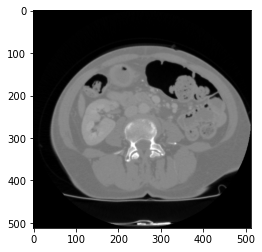

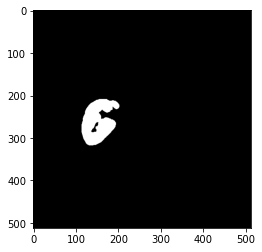

In [26]:
# next(train_dataloader)
x, y = train_data[0]
image = x
mask = y

print(image.shape)
print(mask.shape)

plt.imshow(image[100,:,:].numpy(), cmap='gray')

plt.figure()
plt.imshow(mask[100,:,:].numpy(), cmap='gray')

# U-Net

In [19]:
from torch import nn
import torch


@torch.jit.script
def autocrop(encoder_layer: torch.Tensor, decoder_layer: torch.Tensor):
    """
    Center-crops the encoder_layer to the size of the decoder_layer,
    so that merging (concatenation) between levels/blocks is possible.
    This is only necessary for input sizes != 2**n for 'same' padding and always required for 'valid' padding.
    """
    if encoder_layer.shape[2:] != decoder_layer.shape[2:]:
        ds = encoder_layer.shape[2:]
        es = decoder_layer.shape[2:]
        assert ds[0] >= es[0]
        assert ds[1] >= es[1]
        if encoder_layer.dim() == 4:  # 2D
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2)
                            ]
        elif encoder_layer.dim() == 5:  # 3D
            assert ds[2] >= es[2]
            encoder_layer = encoder_layer[
                            :,
                            :,
                            ((ds[0] - es[0]) // 2):((ds[0] + es[0]) // 2),
                            ((ds[1] - es[1]) // 2):((ds[1] + es[1]) // 2),
                            ((ds[2] - es[2]) // 2):((ds[2] + es[2]) // 2),
                            ]
    return encoder_layer, decoder_layer


def conv_layer(dim: int):
    if dim == 3:
        return nn.Conv3d
    elif dim == 2:
        return nn.Conv2d


def get_conv_layer(in_channels: int,
                   out_channels: int,
                   kernel_size: int = 3,
                   stride: int = 1,
                   padding: int = 1,
                   bias: bool = True,
                   dim: int = 2):
    return conv_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding,
                           bias=bias)


def conv_transpose_layer(dim: int):
    if dim == 3:
        return nn.ConvTranspose3d
    elif dim == 2:
        return nn.ConvTranspose2d


def get_up_layer(in_channels: int,
                 out_channels: int,
                 kernel_size: int = 2,
                 stride: int = 2,
                 dim: int = 3,
                 up_mode: str = 'transposed',
                 ):
    if up_mode == 'transposed':
        return conv_transpose_layer(dim)(in_channels, out_channels, kernel_size=kernel_size, stride=stride)
    else:
        return nn.Upsample(scale_factor=2.0, mode=up_mode)


def maxpool_layer(dim: int):
    if dim == 3:
        return nn.MaxPool3d
    elif dim == 2:
        return nn.MaxPool2d


def get_maxpool_layer(kernel_size: int = 2,
                      stride: int = 2,
                      padding: int = 0,
                      dim: int = 2):
    return maxpool_layer(dim=dim)(kernel_size=kernel_size, stride=stride, padding=padding)


def get_activation(activation: str):
    if activation == 'relu':
        return nn.ReLU()
    elif activation == 'leaky':
        return nn.LeakyReLU(negative_slope=0.1)
    elif activation == 'elu':
        return nn.ELU()


def get_normalization(normalization: str,
                      num_channels: int,
                      dim: int):
    if normalization == 'batch':
        if dim == 3:
            return nn.BatchNorm3d(num_channels)
        elif dim == 2:
            return nn.BatchNorm2d(num_channels)
    elif normalization == 'instance':
        if dim == 3:
            return nn.InstanceNorm3d(num_channels)
        elif dim == 2:
            return nn.InstanceNorm2d(num_channels)
    elif 'group' in normalization:
        num_groups = int(normalization.partition('group')[-1])  # get the group size from string
        return nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)


class Concatenate(nn.Module):
    def __init__(self):
        super(Concatenate, self).__init__()

    def forward(self, layer_1, layer_2):
        x = torch.cat((layer_1, layer_2), 1)

        return x


class DownBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 MaxPool.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 pooling: bool = True,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: str = 2,
                 conv_mode: str = 'same'):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.pooling = pooling
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation

        # conv layers
        self.conv1 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # pooling layer
        if self.pooling:
            self.pool = get_maxpool_layer(kernel_size=2, stride=2, padding=0, dim=self.dim)

        # activation layers
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

    def forward(self, x):
        y = self.conv1(x)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # activation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2

        before_pooling = y  # save the outputs before the pooling operation
        if self.pooling:
            y = self.pool(y)  # pooling
        return y, before_pooling


class UpBlock(nn.Module):
    """
    A helper Module that performs 2 Convolutions and 1 UpConvolution/Upsample.
    An activation follows each convolution.
    A normalization layer follows each convolution.
    """

    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 activation: str = 'relu',
                 normalization: str = None,
                 dim: int = 3,
                 conv_mode: str = 'same',
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalization = normalization
        if conv_mode == 'same':
            self.padding = 1
        elif conv_mode == 'valid':
            self.padding = 0
        self.dim = dim
        self.activation = activation
        self.up_mode = up_mode

        # upconvolution/upsample layer
        self.up = get_up_layer(self.in_channels, self.out_channels, kernel_size=2, stride=2, dim=self.dim,
                               up_mode=self.up_mode)

        # conv layers
        self.conv0 = get_conv_layer(self.in_channels, self.out_channels, kernel_size=1, stride=1, padding=0,
                                    bias=True, dim=self.dim)
        self.conv1 = get_conv_layer(2 * self.out_channels, self.out_channels, kernel_size=3, stride=1,
                                    padding=self.padding,
                                    bias=True, dim=self.dim)
        self.conv2 = get_conv_layer(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=self.padding,
                                    bias=True, dim=self.dim)

        # activation layers
        self.act0 = get_activation(self.activation)
        self.act1 = get_activation(self.activation)
        self.act2 = get_activation(self.activation)

        # normalization layers
        if self.normalization:
            self.norm0 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm1 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)
            self.norm2 = get_normalization(normalization=self.normalization, num_channels=self.out_channels,
                                           dim=self.dim)

        # concatenate layer
        self.concat = Concatenate()

    def forward(self, encoder_layer, decoder_layer):
        """ Forward pass
        Arguments:
            encoder_layer: Tensor from the encoder pathway
            decoder_layer: Tensor from the decoder pathway (to be up'd)
        """
        up_layer = self.up(decoder_layer)  # up-convolution/up-sampling
        cropped_encoder_layer, dec_layer = autocrop(encoder_layer, up_layer)  # cropping

        if self.up_mode != 'transposed':
            # We need to reduce the channel dimension with a conv layer
            up_layer = self.conv0(up_layer)  # convolution 0
        up_layer = self.act0(up_layer)  # activation 0
        if self.normalization:
            up_layer = self.norm0(up_layer)  # normalization 0

        merged_layer = self.concat(up_layer, cropped_encoder_layer)  # concatenation
        y = self.conv1(merged_layer)  # convolution 1
        y = self.act1(y)  # activation 1
        if self.normalization:
            y = self.norm1(y)  # normalization 1
        y = self.conv2(y)  # convolution 2
        y = self.act2(y)  # acivation 2
        if self.normalization:
            y = self.norm2(y)  # normalization 2
        return y


class UNet(nn.Module):
    def __init__(self,
                 in_channels: int = 1,
                 out_channels: int = 2,
                 n_blocks: int = 4,
                 start_filters: int = 32,
                 activation: str = 'relu',
                 normalization: str = 'batch',
                 conv_mode: str = 'same',
                 dim: int = 2,
                 up_mode: str = 'transposed'
                 ):
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.n_blocks = n_blocks
        self.start_filters = start_filters
        self.activation = activation
        self.normalization = normalization
        self.conv_mode = conv_mode
        self.dim = dim
        self.up_mode = up_mode

        self.down_blocks = []
        self.up_blocks = []

        # create encoder path
        for i in range(self.n_blocks):
            num_filters_in = self.in_channels if i == 0 else num_filters_out
            num_filters_out = self.start_filters * (2 ** i)
            pooling = True if i < self.n_blocks - 1 else False

            down_block = DownBlock(in_channels=num_filters_in,
                                   out_channels=num_filters_out,
                                   pooling=pooling,
                                   activation=self.activation,
                                   normalization=self.normalization,
                                   conv_mode=self.conv_mode,
                                   dim=self.dim)

            self.down_blocks.append(down_block)

        # create decoder path (requires only n_blocks-1 blocks)
        for i in range(n_blocks - 1):
            num_filters_in = num_filters_out
            num_filters_out = num_filters_in // 2

            up_block = UpBlock(in_channels=num_filters_in,
                               out_channels=num_filters_out,
                               activation=self.activation,
                               normalization=self.normalization,
                               conv_mode=self.conv_mode,
                               dim=self.dim,
                               up_mode=self.up_mode)

            self.up_blocks.append(up_block)

        # final convolution
        self.conv_final = get_conv_layer(num_filters_out, self.out_channels, kernel_size=1, stride=1, padding=0,
                                         bias=True, dim=self.dim)

        # add the list of modules to current module
        self.down_blocks = nn.ModuleList(self.down_blocks)
        self.up_blocks = nn.ModuleList(self.up_blocks)

        # initialize the weights
        self.initialize_parameters()

    @staticmethod
    def weight_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.weight, **kwargs)  # weights

    @staticmethod
    def bias_init(module, method, **kwargs):
        if isinstance(module, (nn.Conv3d, nn.Conv2d, nn.ConvTranspose3d, nn.ConvTranspose2d)):
            method(module.bias, **kwargs)  # bias

    def initialize_parameters(self,
                              method_weights=nn.init.xavier_uniform_,
                              method_bias=nn.init.zeros_,
                              kwargs_weights={},
                              kwargs_bias={}
                              ):
        for module in self.modules():
            self.weight_init(module, method_weights, **kwargs_weights)  # initialize weights
            self.bias_init(module, method_bias, **kwargs_bias)  # initialize bias

    def forward(self, x: torch.tensor):
        encoder_output = []

        # Encoder pathway
        for module in self.down_blocks:
            x, before_pooling = module(x)
            encoder_output.append(before_pooling)

        # Decoder pathway
        for i, module in enumerate(self.up_blocks):
            before_pool = encoder_output[-(i + 2)]
            x = module(before_pool, x)

        x = self.conv_final(x)

        return x

    def __repr__(self):
        attributes = {attr_key: self.__dict__[attr_key] for attr_key in self.__dict__.keys() if '_' not in attr_key[0] and 'training' not in attr_key}
        d = {self.__class__.__name__: attributes}
        return f'{d}'


Out: torch.Size([1, 1, 512, 512])


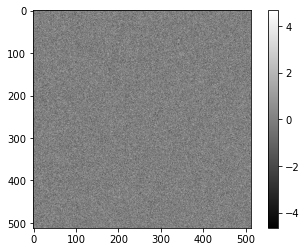

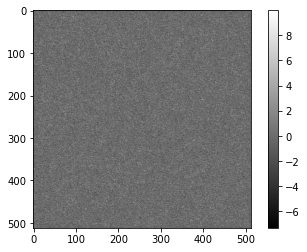

In [21]:
# from unet import UNet
model = UNet(in_channels=1,
             out_channels=1,
             n_blocks=4,
             start_filters=32,
             activation='relu',
             normalization='batch',
             conv_mode='same',
             dim=2)

x = torch.randn(size=(1, 1, 512, 512), dtype=torch.float32)
with torch.no_grad():
    out = model(x)

print(f'Out: {out.shape}')

plt.imshow(x[0,0,:,:,], cmap='gray')
plt.colorbar()

plt.figure()
plt.imshow(out[0,0,:,:,], cmap='gray')
plt.colorbar()

In [27]:

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break


TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'NoneType'>

In [24]:
# loss = torch.nn.BCELoss(weight=None)
x_new = x.reshape([1,1,1,1,1,512,512])
x_new.shape


torch.Size([1, 1, 1, 1, 1, 512, 512])